In [1]:
# pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

In [1]:
import os
import time
import uuid
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
import json
import numpy as np
import albumentations as alb

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [11]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [3]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [4]:
images.as_numpy_iterator().next()

b'data\\images\\2f4a5870-a3e7-11ed-b2bc-48ba4e89b37b.jpg'

In [5]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [6]:
images = images.map(load_image)

In [7]:
images.as_numpy_iterator().next()

array([[[132, 135, 108],
        [132, 134, 110],
        [132, 134, 112],
        ...,
        [191, 190, 206],
        [193, 190, 207],
        [194, 191, 208]],

       [[130, 134, 109],
        [130, 134, 111],
        [130, 133, 112],
        ...,
        [189, 188, 202],
        [191, 189, 203],
        [191, 189, 203]],

       [[130, 135, 115],
        [130, 135, 115],
        [130, 134, 117],
        ...,
        [189, 189, 201],
        [189, 189, 201],
        [189, 189, 201]],

       ...,

       [[154, 107,  63],
        [153, 106,  60],
        [152, 108,  63],
        ...,
        [121, 129, 106],
        [119, 129, 105],
        [117, 130, 104]],

       [[150, 106,  59],
        [149, 105,  56],
        [150, 106,  59],
        ...,
        [123, 129, 103],
        [119, 130, 100],
        [117, 131,  98]],

       [[149, 105,  56],
        [148, 104,  55],
        [149, 105,  56],
        ...,
        [122, 129,  98],
        [119, 130,  98],
        [117, 131,  96]]

In [8]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [9]:
image_generator = images.batch(4).as_numpy_iterator()

In [10]:
plot_images = image_generator.next()

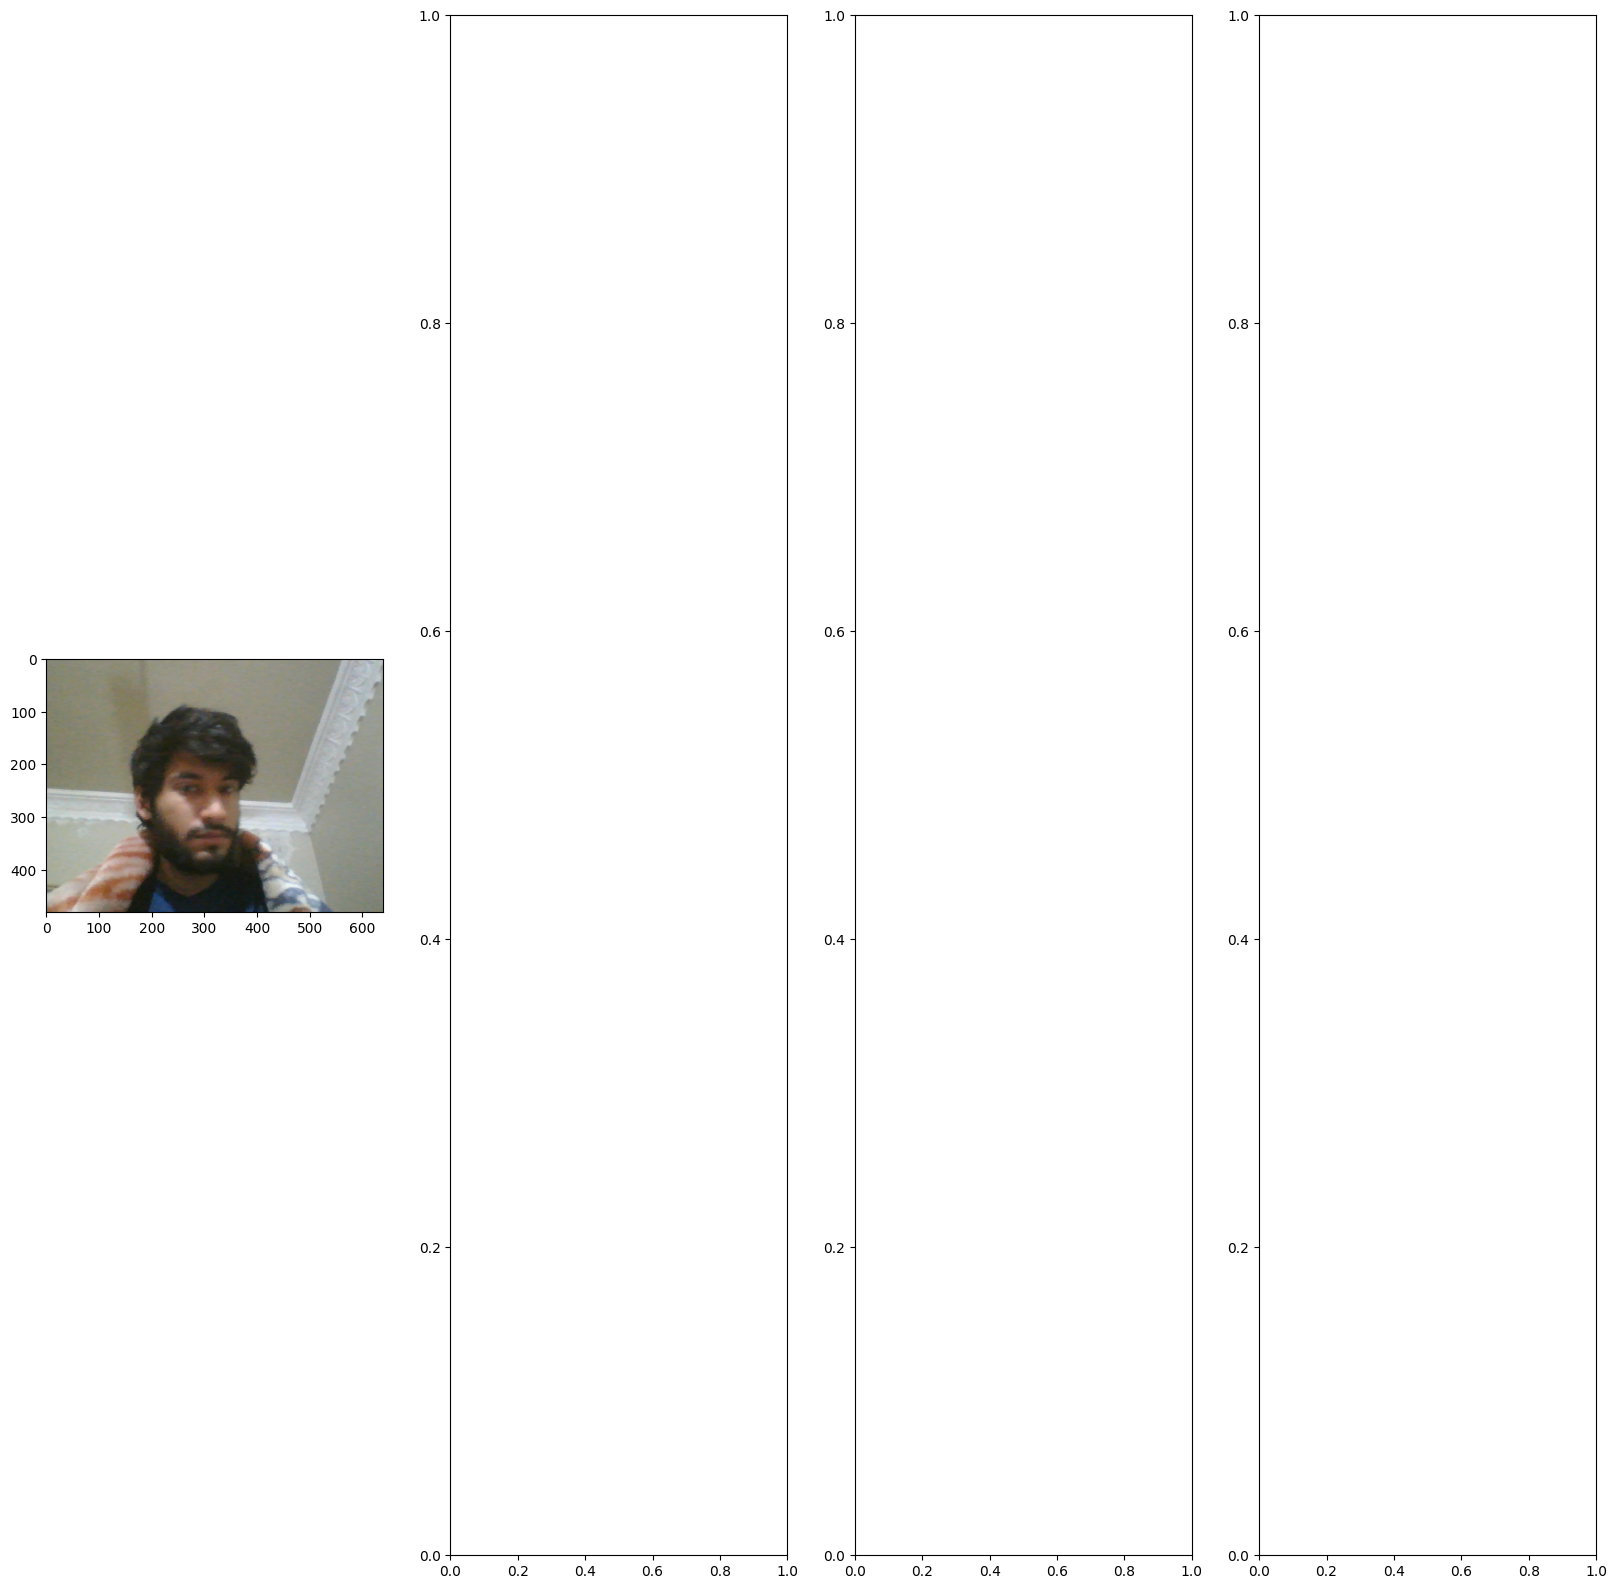

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [12]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)     

In [13]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [14]:
img = cv2.imread(os.path.join('data','train', 'images','2ef7f7c4-a3e7-11ed-bf4c-48ba4e89b37b.jpg'))

In [15]:
with open(os.path.join('data', 'train', 'labels', '2ef7f7c4-a3e7-11ed-bf4c-48ba4e89b37b.json'), 'r') as f:
    label = json.load(f)

In [16]:
label['shapes'][0]['points']

[[175.3639846743295, 92.68199233716474],
 [414.0613026819923, 427.16475095785444]]

In [17]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [18]:
coords

[175.3639846743295, 92.68199233716474, 414.0613026819923, 427.16475095785444]

In [19]:
coords = list(np.divide(coords, [640,480,640,480]))

In [20]:
coords

[0.27400622605363983,
 0.19308748403575987,
 0.6469707854406129,
 0.8899265644955301]

In [21]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [22]:
augmented['bboxes'][0][2:]

(0.6956917837377606, 0.9070327799063432)

In [23]:
augmented['bboxes']

[(0.16525329927628774,
  0.16373776074925497,
  0.6956917837377606,
  0.9070327799063432)]

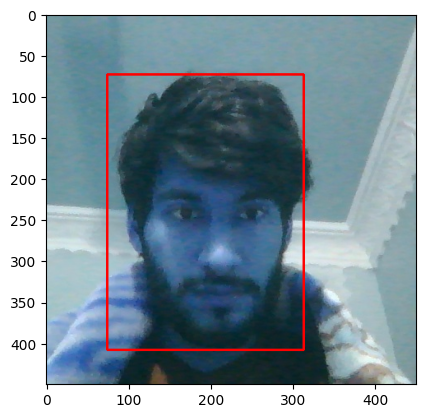

In [24]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [25]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'Images')):
        img = cv2.imread(os.path.join('data', partition, 'Images', image))
        
        # print(os.path.join('data', partition, 'Images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))
            # print(coords)
            
            
            

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                
                # xs = os.path.join('aug_data', partition, 'Images', f'{image.split(".")[0]}.{x}.jpg')
                # print(xs)
                cv2.imwrite(os.path.join('data/aug_data', partition, 'Images', f'{image.split(".")[0]}-{x}.jpg'), augmented['image'])
                

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    # print("True")
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                xname = os.path.join('data/aug_data', partition, 'labels', f'{image.split(".")[0]}-{x}.json')
                # print(xname)
                with open(xname, "w") as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.2488625478927203, 0.18670178799489143, 0.0, 0.8181336254048315, 'face'].
x_max is less than or equal to x_min for bbox [0.348838601532567, 0.17871966794380587, 4.4408920985006264e-17, 0.8074404032641301, 'face'].
x_max is less than or equal to x_min for bbox [0.32848419540229884, 0.1795178799489144, 0.0, 0.8275080931013993, 'face'].
x_max is less than or equal to x_min for bbox [0.43803879310344823, 0.006305874840357582, 8.881784197001253e-17, 0.8221241561758801, 'face'].
x_max is less than or equal to x_min for bbox [0.15607040229885055, 0.10209131545338442, 0.0, 0.8886550842530642, 'face'].
x_max is less than or equal to x_min for bbox [0.21414032567049807, 0.008700510855683252, 4.4408920985006264e-17, 0.8901882006527598, 'face'].
x_max is less than or equal to x_min for bbox [0.6763050766283525, 0.010296934865900366, 0.34105603448275856, 0.5339240102171137, 'face'].
x_max is less than or equal to x_min for bbox [0.6715158045977011, 0.

In [27]:
train_images = tf.data.Dataset.list_files('data\\aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [28]:
test_images = tf.data.Dataset.list_files('data\\aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [29]:
val_images = tf.data.Dataset.list_files('data\\aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [34]:
train_images.as_numpy_iterator().next()

array([[[0.7841299 , 0.7473652 , 0.7129902 ],
        [0.84430146, 0.80606616, 0.78498775],
        [0.8495098 , 0.8034314 , 0.7848039 ],
        ...,
        [0.76960784, 0.7357843 , 0.7395833 ],
        [0.7860907 , 0.76648283, 0.7547181 ],
        [0.6482843 , 0.6422794 , 0.65416664]],

       [[0.7811887 , 0.7147059 , 0.66452205],
        [0.8192402 , 0.7624387 , 0.7276348 ],
        [0.8784314 , 0.8186275 , 0.7911765 ],
        ...,
        [0.82941175, 0.81194854, 0.7785539 ],
        [0.8346201 , 0.8124387 , 0.81096816],
        [0.6720588 , 0.68057597, 0.7199755 ]],

       [[0.79154414, 0.70055145, 0.64840686],
        [0.77800244, 0.7004902 , 0.6657475 ],
        [0.8777574 , 0.80281866, 0.78658086],
        ...,
        [0.8268995 , 0.81807595, 0.8208946 ],
        [0.8188726 , 0.8213235 , 0.83639705],
        [0.63596815, 0.6518995 , 0.69509804]],

       ...,

       [[0.578125  , 0.5428309 , 0.41599265],
        [0.56556374, 0.52892154, 0.39895833],
        [0.5785539 , 0

In [35]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [36]:
train_labels = tf.data.Dataset.list_files('data\\aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [37]:
test_labels = tf.data.Dataset.list_files('data\\aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [38]:
val_labels = tf.data.Dataset.list_files('data\\aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [39]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2245, 0.1306, 0.741 , 0.8594], dtype=float16))

In [40]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(4320, 4320, 960, 960, 1020, 1020)

In [41]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [42]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [43]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [44]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.3867 , 0.969  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.5493 , 0.05945, 1.     , 0.7627 ],
        [0.2119 , 0.1309 , 0.6836 , 0.829  ],
        [0.0964 , 0.06854, 0.627  , 0.812  ],
        [0.2124 , 0.1448 , 0.731  , 0.846  ],
        [0.405  , 0.2397 , 0.907  , 0.8784 ]], dtype=float16))